In [1]:
import cv2
import numpy as np
import onnxruntime as rt
import matplotlib
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot
from rasterio.features import shapes
from shapely.geometry import shape
import pandas as pd
import geopandas as gpd
from glob import glob
import os
import json
plt.rcParams["figure.figsize"] = (10, 10)

with open("/mnt/Inputs/coco_filtered_maxar.json") as f:
    coco = json.load(f)
files = pd.DataFrame(coco["images"])
files.file_name = "/mnt/retrolens/" + files.file_name
files

,id,file_name,width,height
0,2,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800
1,3,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800
2,8,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800
3,10,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800
4,11,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800
...,...,...,...,...
2889,10513,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800
2890,10515,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800
2891,10516,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800
2892,10517,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800


In [2]:
# Read a sample image
filename = files.file_name.sample(1).iloc[0]
print(filename)
image = rasterio.open(filename)

/mnt/retrolens/training_tiles/MaxarImagery/HighFreq/Northland/MarsdenPoint/Imagery/Stack/MarsdenPoint_03MAY2021/MarsdenPoint_03MAY2021_1731791_6026432.tif


In [3]:
true_df = gpd.read_file(os.path.splitext(filename)[0] + ".geojson")
true_df

,level_0,level_1,level_2,area,area_inland,fraction_inland,class,origarea,origlen,partialDec,truncated,geometry
0,0,0,1,209770.126502,13761.138623,0.065601,sea,209770.126502,0,0.609731,1,"POLYGON ((1732178.026 6026032.488, 1731791.736..."
1,0,0,2,491581.671026,472538.549784,0.961262,land,491581.671026,0,0.054137,1,"POLYGON ((1732110.822 6026419.416, 1732106.059..."


<Axes: >

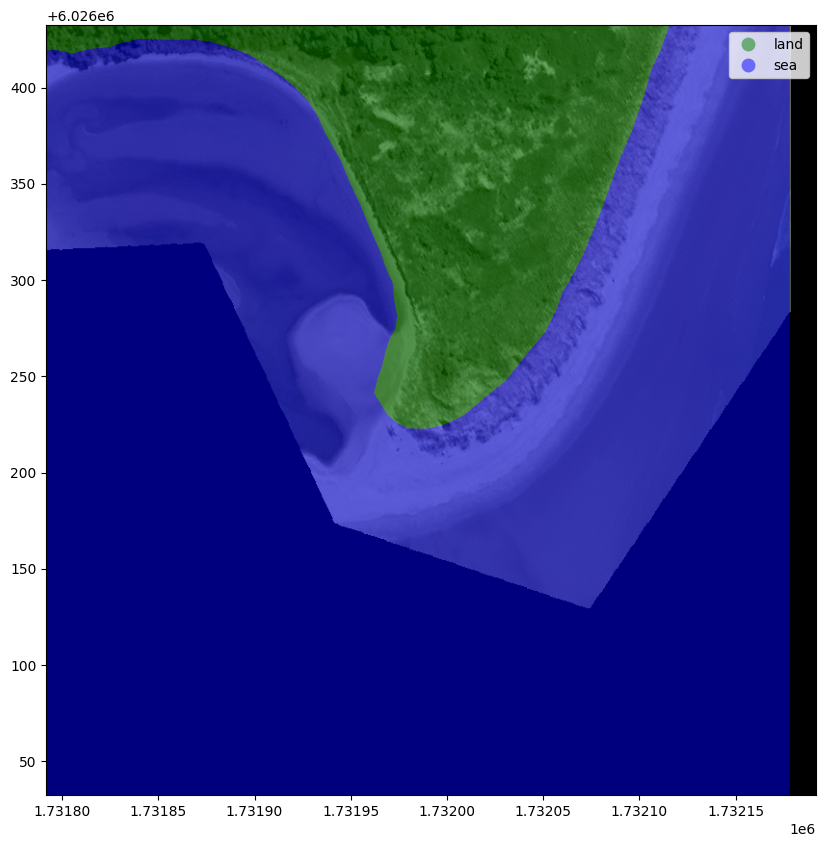

In [4]:
fig, ax = plt.subplots()
ax = rasterio.plot.show(image, ax=ax)
cmap = matplotlib.colors.ListedColormap(['green', 'blue'])
true_df.plot(column="class", cmap=cmap, legend=True, ax=ax, alpha=.5)

In [5]:
# Read the image data as a numpy array
image_data = rasterio.plot.reshape_as_image(image.read())

In [6]:
image.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 800, 'height': 800, 'count': 3, 'crs': CRS.from_epsg(2193), 'transform': Affine(0.5000060237087891, 0.0, 1731791.7359674843,
       0.0, -0.5000060237087891, 6026432.488226468), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

In [7]:
# Check which parts of the image are black
black = image_data.sum(axis=2) == 0
black.sum() / len(black.flat)

0.4823828125

,geometry,class,area
18,"POLYGON ((1732127.740 6026432.488, 1732178.241...",0.0,47739.900264
16,"POLYGON ((1731791.736 6026432.488, 1731791.736...",1.0,30771.741427
12,"POLYGON ((1732132.740 6026301.487, 1732135.240...",1.0,1476.285570
0,"POLYGON ((1731868.237 6026379.988, 1731874.737...",1.0,1451.784980
2,"POLYGON ((1732150.740 6026356.987, 1732151.740...",1.0,424.510228
3,"POLYGON ((1731906.237 6026333.487, 1731909.237...",1.0,408.259837
1,"POLYGON ((1731825.736 6026335.487, 1731837.237...",1.0,343.008265
5,"POLYGON ((1731944.738 6026261.986, 1731946.238...",1.0,97.752355
13,"POLYGON ((1731915.737 6026229.986, 1731915.737...",1.0,45.001084
4,"POLYGON ((1731934.238 6026303.487, 1731937.238...",1.0,28.750693


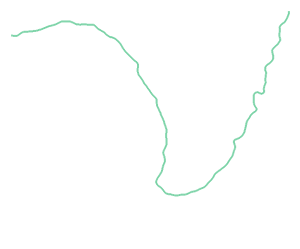

In [8]:
def predict(inp_image):

    model_path = '/mnt/output/land_bodies_model_long.onnx'
    inp_dim = inp_image.shape[:2]

    image = cv2.resize(inp_image, (256, 256))
    image = np.array(image, dtype=np.float32) / 255.0
    image = np.transpose(image, (2, 0, 1))
    image = np.expand_dims(image, axis=0)

    session = rt.InferenceSession(model_path)
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name

    pred_onx = session.run([output_name], {input_name: image.astype(np.float32)})[0]
    pred_onx = pred_onx > 0.5
    pred_onx = pred_onx * 255
    pred_onx = cv2.resize(pred_onx[0, 0].astype(np.uint8) , (inp_dim[1], inp_dim[0]))
    return pred_onx

mask = predict(image_data) / 255
#mask[black] = np.nan
cmap = matplotlib.colors.ListedColormap(['blue', 'green'])
blur = cv2.GaussianBlur(mask, (15,15), sigmaX=15)
blur = blur.round()

# Vectorise raster
shape_gen = ((shape(s), v) for s, v in shapes(blur.astype(np.uint8), mask=~black, transform=image.transform))
# Convert shapes to GeoDataFrame, taking CRS from the image
df = gpd.GeoDataFrame(dict(zip(["geometry", "class"], zip(*shape_gen))), crs=image.crs)
# Sort by area descending
df["area"] = df.area
df.sort_values(by="area", inplace=True, ascending=False)
display(df)
# Take the largest land and the largest sea polygons
land_poly = df.geometry[df["class"] == 1].iloc[0]
sea_poly = df.geometry[df["class"] == 0].iloc[0]
# Return the intersection thereof (EOV)
line = land_poly.intersection(sea_poly)
line

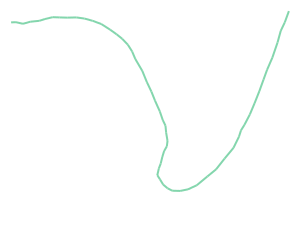

In [9]:
true_df.sort_values(by="area", inplace=True, ascending=False)
# Take the largest land and the largest sea polygons
land_poly = true_df.geometry[true_df["class"] == "land"].iloc[0]
sea_poly = true_df.geometry[true_df["class"] == "sea"].iloc[0]
# Return the intersection thereof (EOV)
true_line = land_poly.intersection(sea_poly)
true_line

(6026209.485539894, 6026432.488226468)

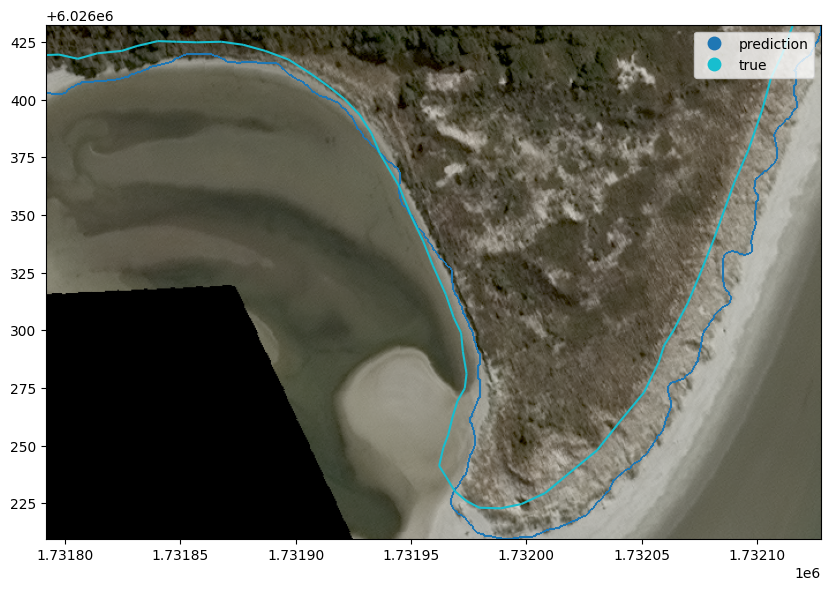

In [10]:
fig, ax = plt.subplots()
ax = rasterio.plot.show(image, ax=ax)

line_df = gpd.GeoDataFrame({"type": ["prediction", "true"]}, geometry=[line, true_line])
line_df.plot(column="type", legend=True, ax=ax)
b = line_df.total_bounds
xlim = ([b[0], b[2]])
ylim = ([b[1], b[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [11]:
# The Hausdorff distance between two geometries is the furthest distance that a point on either geometry can be from the nearest point to it on the other geometry.
true_line.hausdorff_distance(line)

18.887031745082965

In [12]:
error = []
distances = np.arange(0, true_line.length, 1)
for distance in distances:
    # Get a point this distance along the line
    point = true_line.interpolate(distance)
    # Distance from this point to the nearest point on the predicted line
    error.append(point.distance(line))
error = pd.Series(error)
error.describe()

count    601.000000
mean       8.553854
std        4.578073
min        0.018854
25%        4.901269
50%        8.337737
75%       11.983204
max       18.059081
dtype: float64

<Axes: >

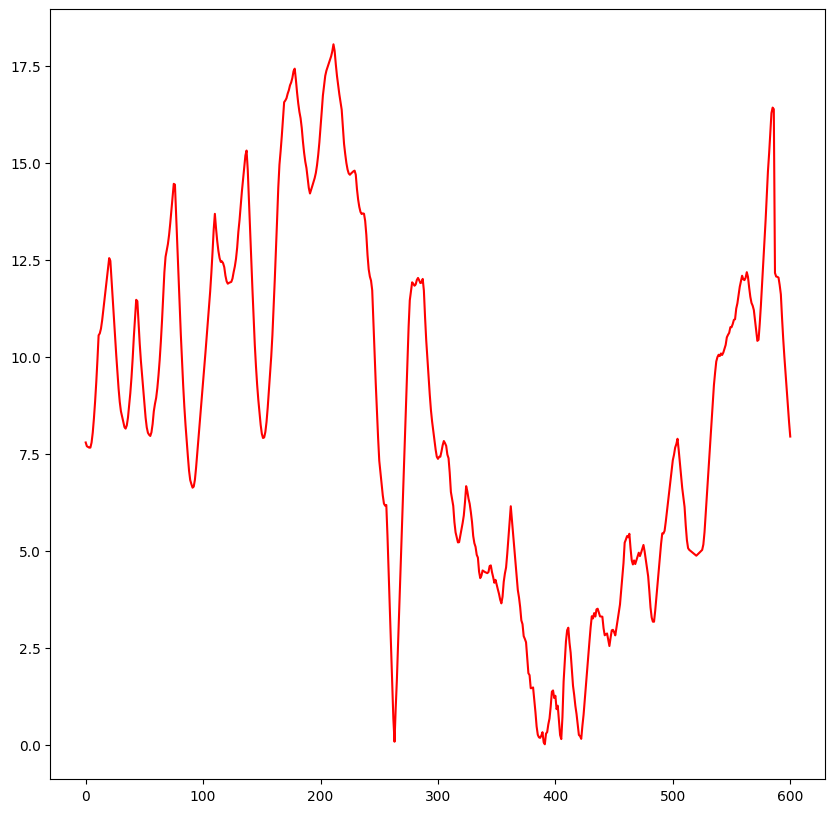

In [13]:
error.plot(color="red")

In [14]:
output_filename = "/mnt/output/shapefiles/" + os.path.splitext(os.path.basename(filename))[0] + ".shp"
output_filename

'/mnt/output/shapefiles/MarsdenPoint_03MAY2021_1731791_6026432.shp'

In [15]:
line_df.to_file(output_filename)